# Scenario 2: CROP RECOMMENDATION SYSTEM
Forest Department of Karnataka is working to protect endangered
species in a tropical rainforest. They have access to a dataset of deforestation
events and a shapefile of the rainforest boundaries. They want to identify
areas of the rainforest that are most at risk of deforestation and focus their
conservation efforts on those areas. Develop a model to solve the problem using
Python and also explain your solution with complete documentation. Upload the solution
ode and documentation in the GitHub Public Repository. Share the code,
visualization, GitHub Link and other stuff in the Google Classroom.

# Introduction

This dataset contain historical satellite data about deforestaion occured in Amazônia. Basically it contains deforestation rates in counties located in Amazônia rainforest. The data was taken from the brazilian National Institute for Space Research (INPE) more specifically I took the data from a data lake created by INPE on the BigQuery.The dataset is available for access [here](https://www.kaggle.com/datasets/diegosilvadefrana/brazilian-deforestation-from-2000-to-2021).

* Counties.csv

| Column Name | Type | Description |
| --- | --- | --- |
| Nome_Microrregião | string | County Name |
| Código Município Completo | int | County Id which the first two numbers represent the state of which the county is located |

--------------------------------------------------------------------


* data.csv
| Column Name | Type | Description |
| --- | --- | --- |
| ano | int | Year |
| id_municipio | int | County Id it is the same as the one located in the table Counties.csv |
| area | int | Total area measured |
| desmatado | float | Total area deforestaed |
| incremento | float | Area measured after thus it is a increment to the previous measure|
| floresta | float | total forest area |
| nuvem | float | area covered by the clouds |
| nao_observado | float | non-measured area |
| nao_floresta | float | non-forest area  |
| hidrografia | float | hydrographic area |

----------------------------------------------------------
* states.csv

| Column Name | Type | Description |
| --- | --- | --- |
| estados_ido | int | State id |
| Estados | int | State name |

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Data Loading

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv("/content/drive/MyDrive/deforestationdata/data.csv")
mun = pd.read_csv("/content/drive/MyDrive/deforestationdata/Counties.csv",sep = ';')
states = pd.read_csv("/content/drive/MyDrive/deforestationdata/states.csv")

In [32]:
df.head()

,ano,id_municipio,area,desmatado,incremento,floresta,nuvem,nao_observado,nao_floresta,hidrografia,municipios,estados
0,2000,1100015,7137,1761.1,NaN,3639.6,0.0,6.1,1708.0,22.2,Cacoal,Rondônia
1,2000,1100023,4481,2661.2,NaN,1730.0,0.0,0.0,89.6,0.2,Ariquemes,Rondônia
2,2000,1100031,1322,851.2,NaN,455.2,0.0,0.6,11.3,3.7,Colorado do Oeste,Rondônia
3,2000,1100049,3821,2311.3,NaN,1477.7,0.0,0.0,26.2,5.8,Cacoal,Rondônia
4,2000,1100056,2805,731.3,NaN,829.3,0.0,0.0,1244.4,0.0,Colorado do Oeste,Rondônia


In [33]:
mun.head()

,Nome_Microrregião,Código Município Completo
0,Cacoal,1100015
1,Cacoal,1100379
2,Ariquemes,1100403
3,Alvorada D'Oeste,1100346
4,Ariquemes,1100023


In [34]:
states.head()

,estados_id,Estados
0,11,Rondônia
1,12,Acre
2,13,Amazonas
3,14,Roraima
4,15,Pará


#### The first thing that we're going to do is to make two new columns in the data.csv table this columns will cotain the county name and state. Thus we'll need the Counties.csv and states.csv tables to make it.

In [5]:
def call(number):
    """This fuction will use the first two characters of a number
    and return all the matches from the states["estados_id"] dataframe"""
    num = str(number)[0:2]
    num = int(num)
    return states[states["estados_id"] == num]

In [6]:
def transform(df):
    """It creates two lists with the name of the county and its state"""
    munic = []
    esta = []
    for i in range(len(df["id_municipio"])):
        ind = mun[mun["Código Município Completo"] == df["id_municipio"][i]]["Nome_Microrregião"].index[0]
        nome_mun = mun[mun["Código Município Completo"] == df["id_municipio"][i]]["Nome_Microrregião"][ind]

        ind_es = mun[mun["Código Município Completo"] == df["id_municipio"][i]]["Código Município Completo"][ind]
        m = call(ind_es)["Estados"].index[0]
        nome_est = call(ind_es)["Estados"][m]

        munic.append(nome_mun)
        esta.append(nome_est)
    return munic, esta

In [7]:
def stats_year(df,nome,Mean):
    """it returns the total sum of the nome column grouped
    by the ano column"""
    sum = df[["ano",nome]].groupby(['ano']).sum()
    media = sum[nome].mean()
    vals = []
    if Mean == False:
        for k in sum[nome]:
            vals.append(k)
    else:
        for k in sum[nome]:
            vals.append(k/media)
    return np.array(vals),sum.index

In [8]:
lista_mun , lista_est = transform(df) #lets add the new columns to our dataset
df["municipios"] = lista_mun
df["estados"] = lista_est

# Geting Statistical Insights
In this section we'll study the correlation between some variables. We'll also analyze the relationship between deforestaion and forest area.

<ipython-input-9-859b9da22407>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = round(new.corr(),2)


<Axes: >

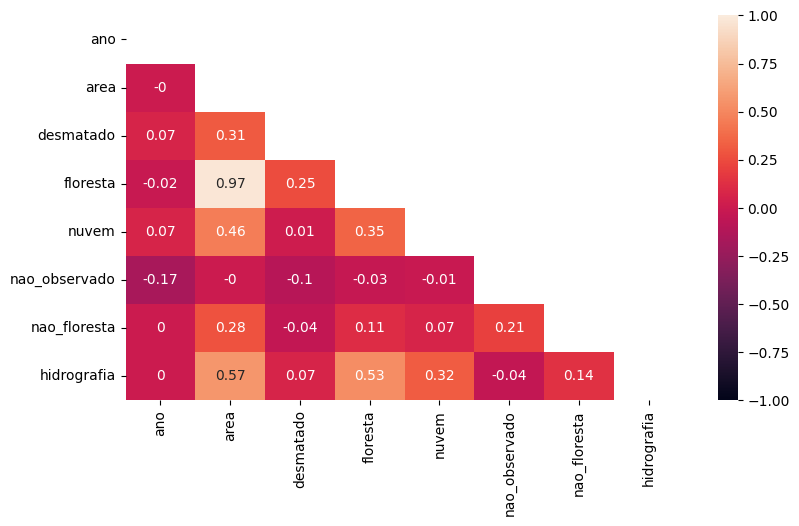

In [9]:
new = df[["ano","area","desmatado","floresta","nuvem","nao_observado","nao_floresta","hidrografia","estados","municipios"]]
corr = round(new.corr(),2)
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(9, 5))

sns.heatmap(corr, mask=mask, vmin=-1,vmax=1,annot = True)

As we see from the correlation matrix above, there is a clear correlation between area and floresta (forest) which is expected since the more area the more forest it can have in. Besides there is a certain correlation between area and desmatado (deforestation) which is again expected.

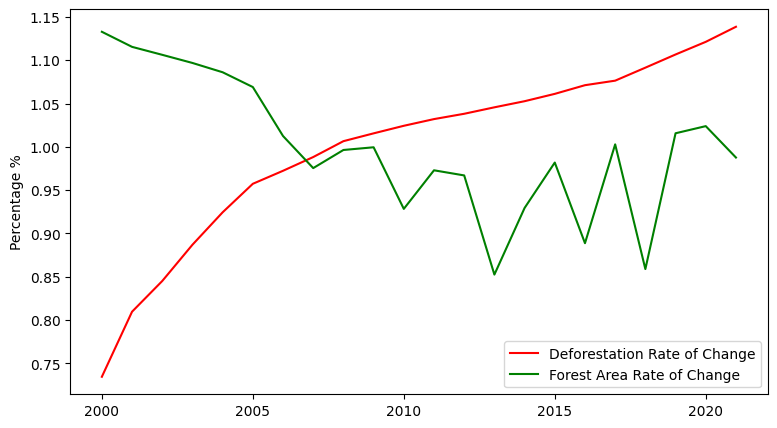

In [10]:
lista1, anos1 = stats_year(df,"desmatado",True)
lista2, anos2 = stats_year(df,"floresta",True)
plt.figure(figsize=(9, 5))
plt.plot(list(anos1),lista1,"r", label="Deforestation Rate of Change")
plt.plot(list(anos2),lista2,"g", label="Forest Area Rate of Change")
plt.ylabel("Percentage %")
plt.legend()

The line plot shows to us that there is a anti-correlationship between deforestation and forest area. But this relationship is unclear from 2005 and beyond because the Forest Area starts to random variate it may be due to social-political response and bias measures.

# Findind The Counties with more deforestation
Lets now find the counties with more deforestation for it we need create a new dataset with the deforestation rate and its respectively county.

In [11]:
anos = list(set(df["ano"]))
year = []
desmat = []
munic = []
esta = []
for ano in anos:

  new = df[df["ano"]==ano]
  new  = new.sort_values(by=['desmatado'], ascending=False)

  year.append(np.array(list(new.copy().iloc[0:10]["ano"])[:]))
  desmat.append(np.array(list(new.copy().iloc[0:10]["desmatado"])[:]))
  munic.append(np.array(list(new.copy().iloc[0:10]["municipios"])[:]))
  esta.append(np.array(list(new.copy().iloc[0:10]["estados"])[:]))

In [12]:
dic = dict()
dic["ano"] = np.array(year).reshape(1,-1)[0]
dic["estado"] = np.array(esta).reshape(1,-1)[0]
dic["desmatado"] = np.array(desmat).reshape(1,-1)[0]
dic["municipio"] = np.array(munic).reshape(1,-1)[0]
novo = pd.DataFrame(dic)
novo

,ano,estado,desmatado,municipio
0,2000,Pará,7212.3,Paragominas
1,2000,Pará,7037.4,São Félix do Xingu
2,2000,Pará,5818.9,Marabá
3,2000,Mato Grosso,5520.7,Arinos
4,2000,Maranhâo,5373.3,Pindaré
...,...,...,...,...
215,2021,Pará,8616.0,Tucuruí
216,2021,Mato Grosso,8272.2,Arinos
217,2021,Pará,7528.9,São Félix do Xingu
218,2021,Pará,7353.5,Conceição do Araguaia


In [13]:
muns = list(Counter(novo["municipio"]))
mat = []
for i in range(len(muns)):

  data = df[df["municipios"] == muns[i]]
  mat.append(stats_year(data,"desmatado",False)[0])

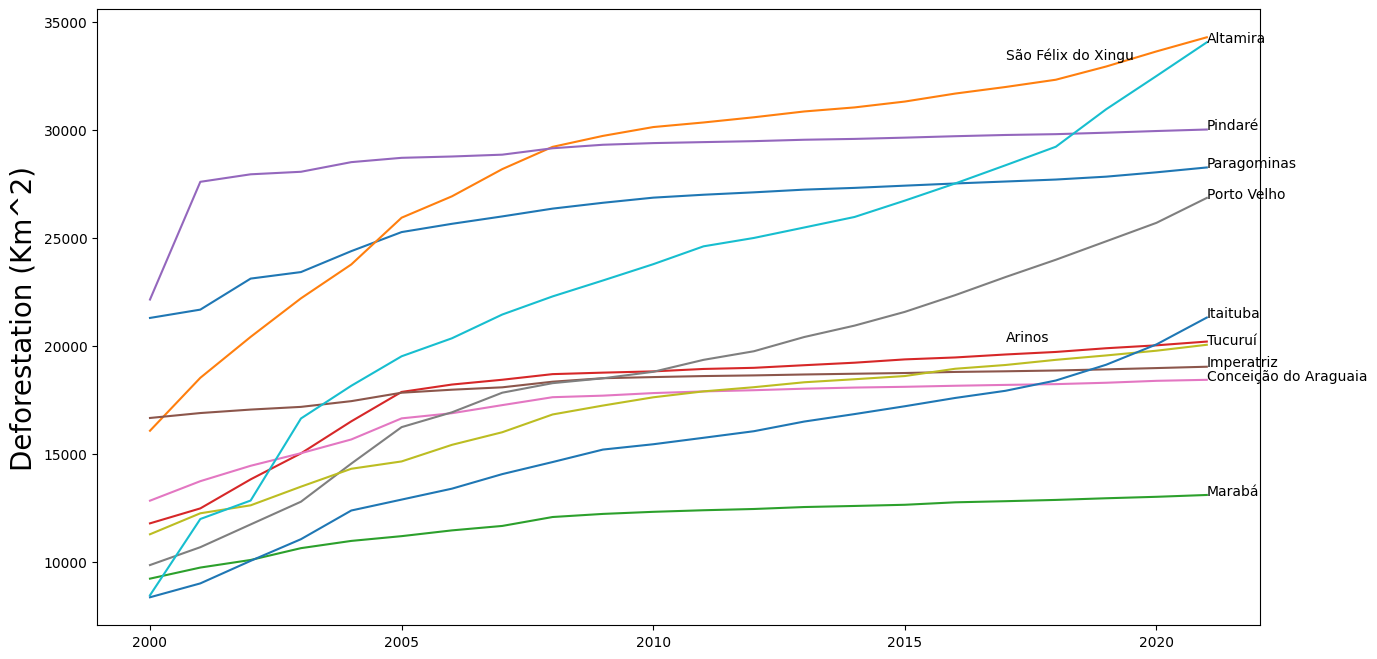

In [14]:
plt.figure(figsize=(15, 8))
for i in range(len(muns)):

  if muns[i] == "São Félix do Xingu":
    plt.plot(list(set(novo.ano)),mat[i])
    plt.text(list(set(novo.ano))[-1]-4, mat[i][-1]-1000, str(muns[i]), fontsize = 10)
  elif muns[i] == "Arinos":
    plt.plot(list(set(novo.ano)),mat[i])
    plt.text(list(set(novo.ano))[-1]-4, mat[i][-1], str(muns[i]), fontsize = 10)
  else:
    plt.plot(list(set(novo.ano)),mat[i])
    plt.text(list(set(novo.ano))[-1], mat[i][-1], str(muns[i]), fontsize = 10)
plt.ylabel("Deforestation (Km^2)",fontsize = 20)
plt.show()

As shown above the counties: São Félix do Xingu, Altamira and Pindaré,. Are the ones with a upward tendency for deforestation from the lasts years. Some others (Paragominas, Arinos,Imperatriz, etc) reached a plateau. But none of them reached a downward tendency yet.  

# Predicting Future Deforestation
Lets now use a Machine learning Algorithm to estimate the total states deforestation for 2022 and 2023. But first we need to make our traind set X from the previous dataset

In [15]:
estd = list(Counter(df["estados"]))
mat = []
for i in range(len(estd)):

   data = df[df["estados"] == estd[i]]
   mat.append(stats_year(data,"desmatado",False)[0])

ano = []
est = []
for estado in estd:
  for i in range(2000,2022):
    ano.append(i)
    est.append(estado)

In [16]:
d = {}
d["ano"] = ano
d["estado"] = est
d["desmatado"] = np.array(mat).reshape(1,-1)[0]

X = pd.DataFrame(d)
labels = list(Counter(X["estado"]))

X["estado"] = LabelEncoder().fit_transform(X["estado"])
Y = X.pop("desmatado")
labels_encod = list(Counter(X["estado"]))

 ## Model
The model that I choose was a ensemble model with three models KNeighborsRegressor, SGDRegressor and BaggingRegressor. According to the big numbers law this three models mixied will result a more precision than use them separately.

In [17]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

## Fine tune Hyperparameters
Before we train our ensembe lets tune separately hyperparameters to the three models using GridSearchCV and then use VotingRegressor to train the model.

In [18]:
KN = KNeighborsRegressor()
bag = BaggingRegressor()

mod = GridSearchCV(estimator=KN,param_grid= {'n_neighbors':[1,2,3,4,5,6,7,8,9,10]},cv=2)

mod2 = GridSearchCV(estimator=bag,param_grid= {'n_estimators':[100,120,130,150,180]},cv=2)

mod3 = GridSearchCV(estimator=SGDRegressor(max_iter=1200,early_stopping=True),param_grid={'penalty':["l1","l2"]} ,cv=2)

vot = VotingRegressor(estimators=[("kn",mod),("bag",mod2),("est",mod3)])

In [19]:
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.1,random_state=True)

In [20]:
vot.fit(X_train,y_train)
y_pred = vot.predict(X_test)
metrics.r2_score(y_test,y_pred)

0.8915152717911808

##### Thus our R^2 is close to 0.89 which isn't bad considerig the training set size. Now lets predict the future states deforestation to 2022 and 2023. #####

In [21]:
m = []
for i in labels_encod:
  for year in range(2022,2024):
      m.append([year,i])
pred = scaler.transform(m)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [22]:
predic = vot.predict(pred)

In [23]:
Df = pd.DataFrame(d)
ano = [i for i in range(2000,2024)]

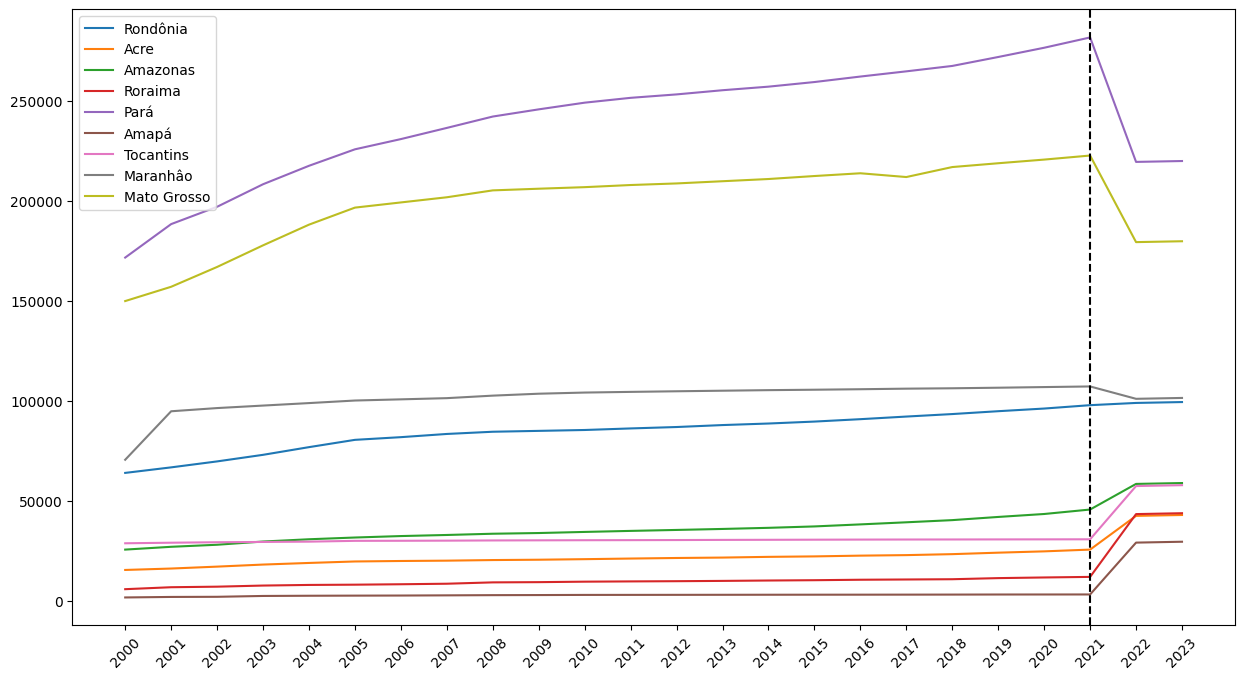

In [24]:
plt.figure(figsize=(15,8))
c = 0
for i in labels:
  dat = Df[Df["estado"] == i]
  es = list(dat["desmatado"])
  es.append(predic[c])
  es.append(predic[c+1])
  plt.plot(ano,es,label = i)
  c+=2
plt.axvline(2021, color='k', linestyle='--')
plt.legend()
plt.xticks(ano, rotation=45)
plt.show()

# Final Conclusions
From the finds shown previously we can conclude that.

1. Amazon deforestation is currently in a high trend
2. The Counties São Félix do Xingu, Altamira and Pindaré have one of the highest deforestation rates, currently.
3. The states Pará and Mato Grosso have one of the highest deforestation rates, currently.

# Analysis and Performance of Regression Model

This present work combined three distinct datasets to analyze the deforestation rate in the Amazon region from the years 2000 to 2020.

After data preparation, the author used hyperparameters to calculate the best model with the aim of predicting the deforestation rate for the years 2022 and 2023.

As a method of error analysis, only the R² calculation was used.

We propose performing calculations for other error metrics to better evaluate the generated model.

R² The R² calculates the percentage of variance that could be predicted by the regression model, that is, how "close" the actual measurements are to our model.

The R² is inherently biased because, depending on the optimizer, it may use data correlation to erroneously increase the R² value. It can only be applied perfectly to models with only one input and does not respond well to overfitting.

**R²**
O R² calcula qual a porcentagem da variança que pôde ser prevista pelo modelo de regressão, ou seja, o quão "próximo" as medidas reais estão do nosso modelo.

O R² é por padrão enviesado, pois, dependendo do otimizador, pode utilizar a correlação dos dados para incrementar erroneamente o valor de R². Só pode ser aplicada perfeitamente em modelos com apenas uma entrada e não responde bem ao Overfitting.

In [25]:
print("R² = ", metrics.r2_score(y_test,vot.predict(X_test)))

R² =  0.8915152717911808


Adjusted R²

It is a more versatile and unbiased alternative measure compared to R². It also aims to represent the percentage of variance that a regression model possesses. However, it takes into account how much a feature contributes to the model.

The formula for Adjusted R² can be written as:

R²a = 1 - ((1-R²)*(N-1))/N-p-1

where N is the number of samples,p is the number of features (input data of the model).

Unlike R², Adjusted R² can be used with more precision and confidence. It can be applied to models with more than one input variable and does not exhibit bias.

In [26]:
def adjusted_r2(y_test, y_pred,X_train):
  adj_r2 = (1 - ((1 - metrics.r2_score(y_test, y_pred)) * (len(y_test) - 1)) /
          (len(y_test) - X_train.shape[1] - 1))

  return adj_r2

print("R² Ajustado = ", adjusted_r2(y_test, y_pred, X_train))

R² Ajustado =  0.8787523625901433


Mean Squared Error (MSE)

It is calculated based on the average of the squared errors of predictions. The higher the MSE value, the worse the model.

It is useful when the problem domain does not tolerate large errors, as predictions that are far from the actual values significantly increase the measure's value. However, as it is a metric squared, it is challenging to interpret.

In [27]:
MSE = metrics.mean_squared_error(y_test, y_pred)
print("MSE = ", MSE)

MSE =  666139389.4579426


Root Mean Squared Error (RMSE)

Similar to adjusted R², RMSE also aims to improve the interpretability of the metric by matching the unit of the data. To achieve this, the square root of MSE is taken.







In [28]:
RMSE = np.sqrt(MSE)
print("RMSE = ", RMSE)

RMSE =  25809.676275729274


Mean Absolute Error (MAE)

It is the average of the distances between predicted and actual values. Since it does not square the values, it is not recommended for sensitive problems. However, it is a robust metric for models that need to predict many data points or seasonal data.

MAE does not readily identify outliers like MSE and RMSE, but its interpretation is more intuitive because it is in the same unit as the values being analyzed.

In [29]:
MAE = metrics.mean_absolute_error(y_test,y_pred)
print("MAE = ", MAE)

MAE =  19663.161770228882


Mean Absolute Percentage Error (MAPE)

In contrast to other metrics, MAPE expresses a percentage obtained by dividing the difference between the predicted y value and the actual y value by the actual y value.

As it is a percentage, it is easy to understand, but it may not perform as well with values that have a very wide possible range.

In [30]:
MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("MAPE = ", MAPE)

MAPE =  118.10274014302311


Root Mean Squared Logarithmic Error (RMSLE)

This error indicator is similar to RMSE, but it uses logarithms to avoid penalizing large differences between the predicted and actual values when both values are very large.

In [31]:
RMSLE = metrics.mean_squared_log_error(y_test,y_pred)
print("RMSLE = ", RMSLE)

RMSLE =  0.6236277930267647


# Final Considerations

Considering what was covered in class and the study of various types of metrics for error calculation in regression models, it is evident that determining the best formula for this calculation is a complex task.

Among all the tested metrics, R² and Adjusted R² seem to have easily understandable values and indicate that the model has good predictive behavior.

On the other hand, MSE, RMSE, and MAE presented values that are difficult to interpret, even though RMSE and MAE are in the same unit as the prediction. Their results suggest that the model is performing poorly.

MAPE and RMSLE, which provide values in percentage terms, also indicate that the model is not well-trained, with MAPE showing a 107% error and RMSLE showing a 56% error.

Based on the obtained data and the difficulty of understanding some of the algorithms for error evaluation, I maintain the author's opinion, suggesting R² or Adjusted R² as metrics for the model.